In [1]:
#@title Standard libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from dataclasses import dataclass
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchsummary import summary
from torchvision import models, transforms

In [2]:
#@title Default hyperparameters

@dataclass                    # To simplify the creation of classes that are mainly used to store data.
class Args:
  cuda: str = "cuda:0"
  train_src: str = "/content/data/training_set/training_set"
  test_src: str = "/content/data/test_set/test_set"
  save_path: str = "/content/"
  seed: int = 42
  batch_size: int = 32
  num_epochs: int = 20
  dropout: float = 0.1
  lr: float = 1e-3
  weight_decay: float = 1e-5
  max_num_trials: int = 3


args = Args()
device = torch.device(args.cuda) if torch.cuda.is_available() else torch.device("cpu")

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

# Data Preparation

In [18]:
#!/bin/bash
!mkdir data

!curl -L -o /content/data/cat-and-dog.zip\
https://www.kaggle.com/api/v1/datasets/download/tongpython/cat-and-dog

!unzip -q /content/data/cat-and-dog.zip -d /content/data

!rm -rf /content/data/cat-and-dog.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  217M  100  217M    0     0  16.8M      0  0:00:12  0:00:12 --:--:-- 20.4M


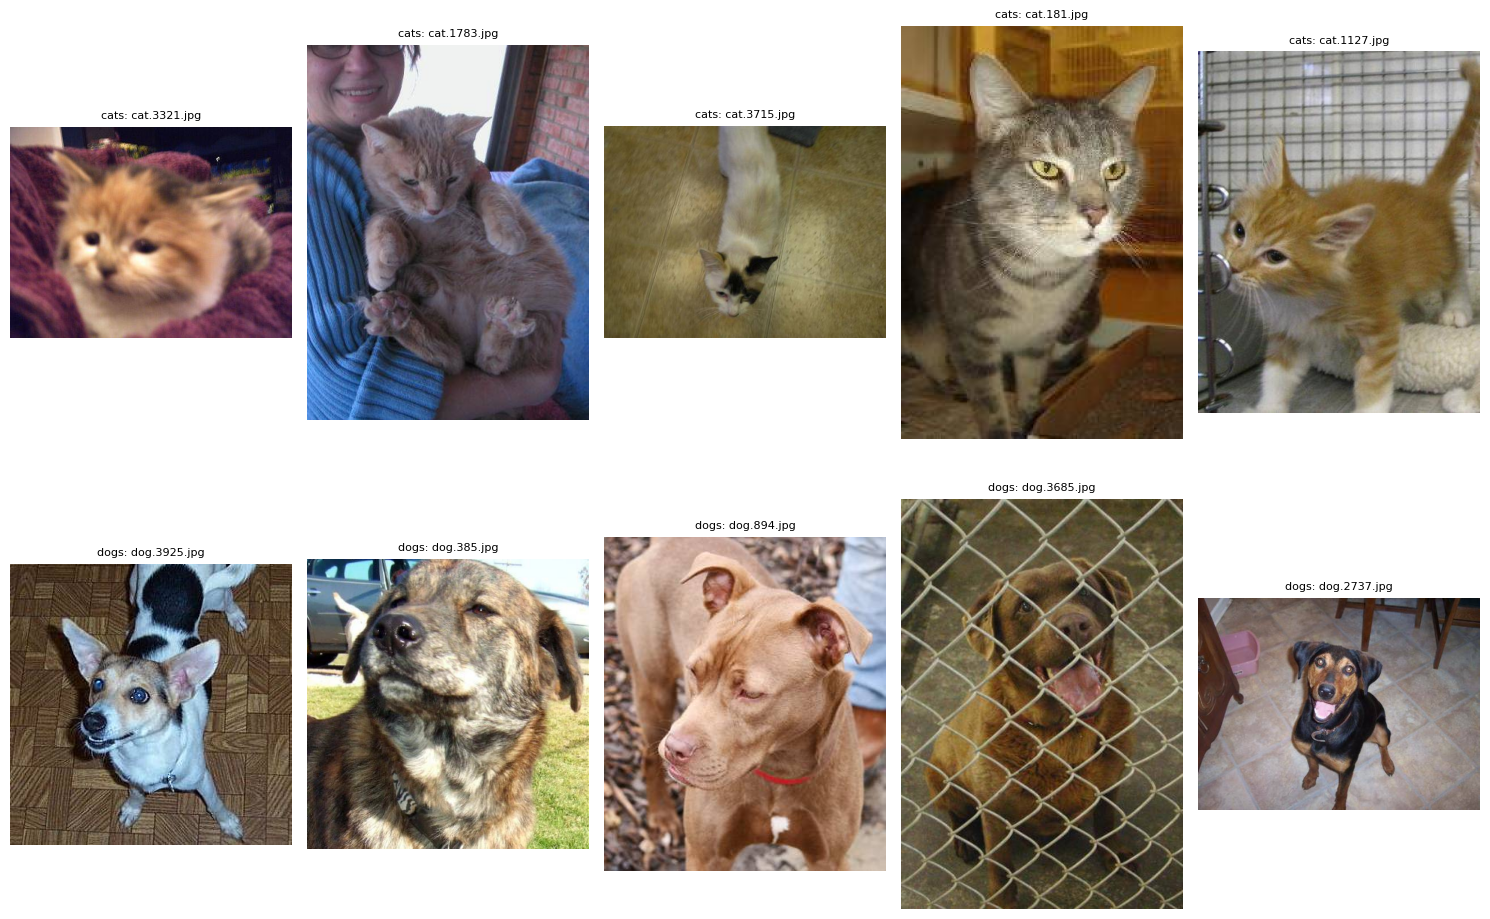

In [ ]:
#@title Plotting data files
def plot_sample_images(base_path, categories, sample_size=5):
    """
    Plot sample images from the dataset using matplotlib.

    Args:
        base_path (str): Path to the dataset folder.
        categories (list): List of category folders (e.g., 'cats', 'dogs').
        sample_size (int): Number of images to display from each category.
    """

    fig, axes = plt.subplots(len(categories), sample_size, figsize=(15, 5 * len(categories)))

    for row, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        images = [f for f in os.listdir(category_path) if f.endswith(('jpg', 'jpeg', 'png'))]

        sampled_images = images[:sample_size]

        for col, img_name in enumerate(sampled_images):
            img_path = os.path.join(category_path, img_name)
            try:
                img = Image.open(img_path)
                ax = axes[row, col] if len(categories) > 1 else axes[col]
                ax.imshow(img)
                ax.set_title(f"{category}: {img_name}", fontsize=8)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    plt.tight_layout()
    plt.show()


# Plot sample images
categories = ["cats", "dogs"]
plot_sample_images(args.train_src, categories, sample_size=5)

In [19]:
#@title Define CatDogDataset class

class CatDogDataset(Dataset):
  def __init__(self, data_dir, transforms=None):
    self.data_dir = data_dir
    self.transforms = transforms
    self.image_paths = []
    self.labels = []

    self.class_names = os.listdir(data_dir)

    self.label_map = {class_name: i for i, class_name in enumerate(self.class_names)}

    for class_name in self.class_names:
      class_dir = os.path.join(data_dir, class_name)
      for image_name in os.listdir(class_dir):
        if image_name.endswith(('jpg', 'jpeg', 'png')):
          image_path = os.path.join(class_dir, image_name)
          self.image_paths.append(image_path)
          self.labels.append(self.label_map[class_name])

  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")

    if self.transforms:
      image = self.transforms(image)

    return image, label

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CatDogDataset(data_dir=args.train_src, transforms=transform)
test_dataset = CatDogDataset(data_dir=args.test_src, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

{'dogs': 0, 'cats': 1}
{'dogs': 0, 'cats': 1}


# Building a simple CNN Model

In [3]:
#@title Create the CNN Model

class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=1):  # ch_in, ch_out, kernel, stride, padding
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(c2)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = Conv(3, 32, 3, 1, 1)
        self.conv2 = Conv(32, 128, 3, 1, 1)
        self.conv3 = Conv(128, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))

        for _ in range(3):
          x = self.pool(self.conv3(x))

        # Flatten before fully connected layers
        x = x.view(-1, 128 * 7 * 7)

        # Apply dropout after flattening and before the fully connected layers
        x = self.dropout(x)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [21]:
num_classes = len(train_dataset.class_names)  # Based on the number of species
model = SimpleCNN(num_classes=num_classes, dropout=args.dropout).to(device)

# Install torchinfo if it's not available, import it if it is
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              Conv-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          36,864
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              Conv-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]         147,456
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             Conv-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         147,456
      BatchNorm2d-14          [-1, 128,

In [25]:
#@title Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [23]:
#@title Training model
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct / total * 100
    return test_loss, test_accuracy



def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, save_path=None, max_num_trials=3):
    model.train()

    # Initialize lists to store the loss and accuracy values
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }

    # Initialize variables to keep track of best test loss
    best_test_loss = float('inf')
    last_model_path = os.path.join(save_path, "last.pt")
    best_model_path = os.path.join(save_path, "best.pt")

    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop with tqdm progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as train_bar:
            for images, labels in train_bar:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track the loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update the progress bar description
                train_bar.set_postfix(loss=running_loss / (train_bar.n + 1), accuracy=(correct / total) * 100)

        avg_loss = running_loss / len(train_loader)

        # Evaluate on the test set
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {correct / total * 100:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

        results["train_loss"].append(avg_loss)
        results["train_acc"].append(correct / total * 100)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_accuracy)

        # Save the model if it is the best so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), best_model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save the last model
        torch.save(model.state_dict(), last_model_path)

        if epochs_without_improvement >= max_num_trials:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    return results


In [ ]:
results = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=args.num_epochs, save_path=args.save_path, max_num_trials=args.max_num_trials)

In [ ]:
#@title Plotting curve after training
def plot_loss_curves(model_results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(results)

# Evaluate on test set

In [27]:
model = SimpleCNN(num_classes=2, dropout=args.dropout).to(device)
model.load_state_dict(torch.load("/content/best.pt", weights_only=True))

test_loss, test_accuracy = evaluate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.4895, Test Accuracy: 85.71%


In [16]:
#@title Prediction
def predict(model, image_path):
  preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

  image = Image.open(image_path)

  # Apply transformations to the image
  image_tensor = preprocess(image)
  image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
  image_tensor = image_tensor.to(device)

  outputs = model(image_tensor)

  _, predicted = torch.max(outputs.data, 1)

  if predicted.item() == 1: print("cat")
  else: print("dog")